# Model Assessor

Demo an analysis pipeline from start to finish.

In [1]:
import xarray as xr
import ocean_data_gateway as odg
import cf_xarray
import pandas as pd
import extract_model as em
import ocean_model_skill_assessor as omsa
import numpy as np
import requests
import ast

In [2]:
# Set up custom vocabulary to be able to refer to variables in xarray Datasets by my selected names
my_custom_criteria_gist = "https://gist.githubusercontent.com/kthyng/c3cc27de6b4449e1776ce79215d5e732/raw/85dae06cd72c3bb490557b83f799f9cc1b6afbf8/my_custom_criteria.py"
response = requests.get(my_custom_criteria_gist)
my_custom_criteria = ast.literal_eval(response.text)
cf_xarray.set_options(custom_criteria=my_custom_criteria)

In [3]:
# # Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# # explicitly connect to the cluster we just created
# client = Client(cluster)
# # client

## Read in model output

This sample ROMS output has multiple time steps so we can compare with a dataset over time.

In [4]:
url = 'https://gcoos5.geos.tamu.edu/thredds/dodsC/NcML/nowcast_agg.nc'
# url = 'http://barataria.geos.tamu.edu/thredds/dodsC/NcML/forecast_his_archive_agg.nc'
dsm = xr.open_dataset(url, chunks={'ocean_time': 1})

# add more cf-xarray info
dsm = dsm.cf.guess_coord_axis()


Set up data search by region based on where the model output is in space and time. Just get 2 days' worth centered around the mean time of the model output.

In [5]:
key = 'ssh'

deltaT = pd.Timedelta('1 days')
meanT = pd.Timestamp(dsm.cf['T'].mean().values)


kw = {
    "min_lon": float(dsm.cf[key].cf['longitude'].min()),
    "max_lon": float(dsm.cf[key].cf['longitude'].max()),
    "min_lat": float(dsm.cf[key].cf['latitude'].min()),
    "max_lat": float(dsm.cf[key].cf['latitude'].max()),
    "min_time": meanT - deltaT,
    "max_time": meanT + deltaT,
}

Some basic processing for model time indices:

In [6]:
# drop duplicate time indices if present
# also limit the time range of the model output to what we are requesting from the data to 
# not waste extra time on the model interpolation
# https://stackoverflow.com/questions/51058379/drop-duplicate-times-in-xarray
_, index = np.unique(dsm.cf['T'], return_index=True)
dsm = dsm.cf.isel(T=index).cf.sel(T=slice(kw['min_time'], kw['max_time']))


# collect together the boundary locations in lon/lat
lona, lonc = dsm.cf[key].cf['longitude'][:,[0,-1]].values.T
lonb, lond = dsm.cf[key].cf['longitude'][[0,-1],:].values
lata, latc = dsm.cf[key].cf['latitude'][:,[0,-1]].values.T
latb, latd = dsm.cf[key].cf['latitude'][[0,-1],:].values
lonsm = np.hstack((lona, lonb, lonc, lond[::-1]))
latsm = np.hstack((lata, latb, latc, latd[::-1]))
boundary = np.vstack((lonsm, latsm)).T


## Search for data 

Next find the data that fits the search criteria we set up plus a few more items. We will do a search by region and in this case are specifically using the IOOS ERDDAP server to look for data. Additionally, we are looking specifically sea surface height data with a particular variable name.

In [7]:
kwargs = {
          'kw': kw,
          'approach': 'region',
          'parallel': False,
          'readers': [odg.erddap],
#                       odg.axds],

          'erddap': {
                          'known_server': ['ioos'],
                           'variables': [
#                                          ['sea_water_practical_salinity']]
#                                          ['salinity','sea_water_practical_salinity']
#                                        ['water_surface_height_above_reference_datum_geoid_localstationdatum',
#                                        'sea_surface_height_amplitude_due_to_geocentric_ocean_tide_geoid_mllw',
                                       ['sea_surface_height_above_sea_level_geoid_mllw']
                           ]
          },
#           'axds': {
#                           'axds_type': ['platform2'],
#                          'variables': ['Salinity']},
}


data = odg.Gateway(**kwargs)

Look at a few of the `dataset_id`s that were found:

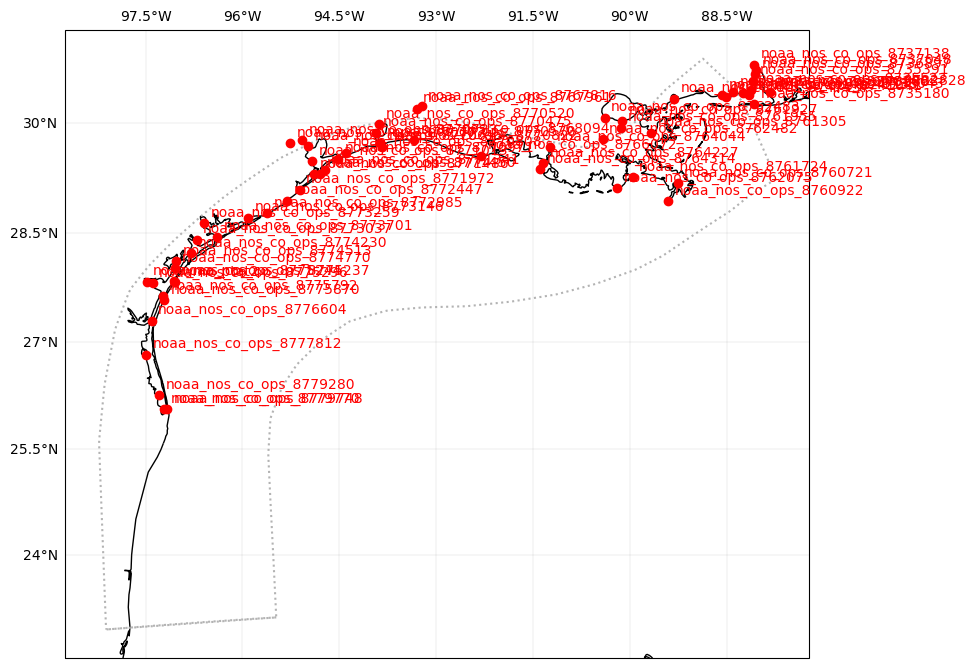

In [8]:
sub = data.meta.loc[data.dataset_ids,['geospatial_lon_max','geospatial_lat_max']]
lls = sub.values
names = list(sub.index.values)
omsa.map.plot(lls, names, boundary, res='10m')#, extent=[-89,-87,30,31])

In [9]:
# remove ids from dataset_ids by list
ids_to_remove = ['noaa_nos_co_ops_8738043', 'noaa_nos_co_ops_8732828', 'noaa_nos_co_ops_8735523', 'noaa_nos_co_ops_8735391',
                 'noaa_nos_co_ops_8736897', 'noaa_nos_co_ops_8737048', 'noaa_nos_co_ops_8737138', 'noaa_nos_co_ops_8735180',
                 'noaa_nos_co_ops_8739803', 'noaa_nos_co_ops_8740166', 'noaa_nos_co_ops_8741533', 'noaa_nos_co_ops_8741041']
for id_remove in ids_to_remove:
    try:
        ind = data.dataset_ids.index(id_remove)
        data.dataset_ids.pop(ind)
    except:
        pass
   

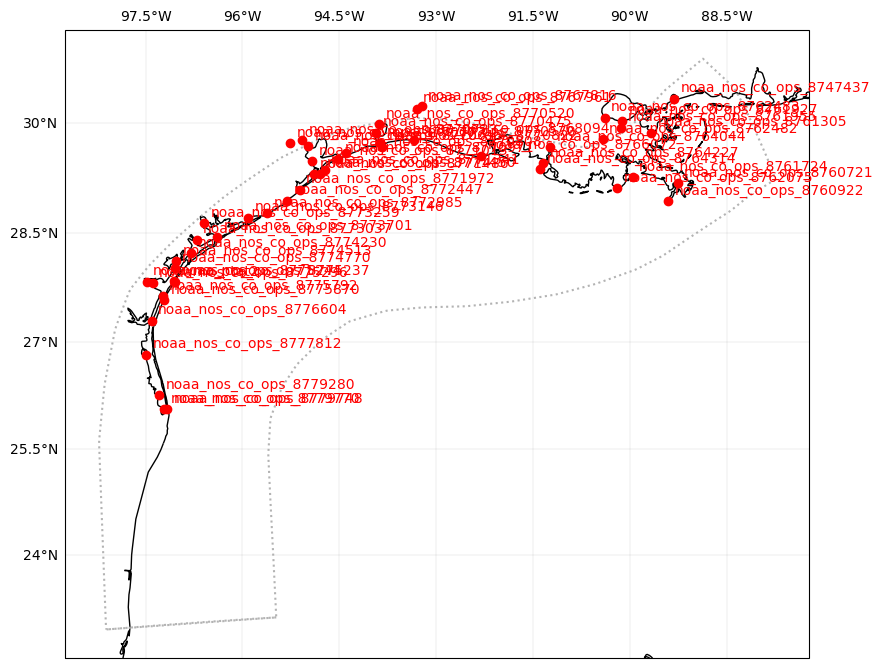

In [10]:
sub = data.meta.loc[data.dataset_ids,['geospatial_lon_max','geospatial_lat_max']]
lls = sub.values
names = list(sub.index.values)
omsa.map.plot(lls, names, boundary, res='10m')#, extent=[-89,-87,30,31])

# For each dataset:

This part of the notebook demonstrates the process for comparing each dataset with the model output.

## Pull out the dataset

For demo purposes, select one dataset by `dataset_id` to compare with the data. We are able to use the syntax `.cf['ssh']` to refer to the sea surface height variable in the dataset due to the custom vocabulary we defined at the top of this notebook for use with `cf-xarray`.

In [11]:
dataset_id = 'noaa_nos_co_ops_8770822'
data[dataset_id].cf['ssh']

<xarray.DataArray 'sea_surface_height_above_sea_level_geoid_mllw' (time: 486, timeseries: 1)>
array([[0.679],
       [0.675],
       [0.684],
       [0.684],
       [0.68 ],
       [0.673],
       [0.671],
       [0.663],
       [0.657],
       [0.656],
       [0.652],
       [0.647],
       [0.638],
       [0.635],
       [0.624],
       [0.623],
       [0.628],
       [0.635],
       [0.635],
       [0.632],
...
       [0.54 ],
       [0.551],
       [0.552],
       [0.562],
       [0.559],
       [0.592],
       [0.593],
       [0.602],
       [0.605],
       [0.609],
       [0.612],
       [0.634],
       [0.632],
       [0.65 ],
       [0.643],
       [0.652],
       [0.669],
       [0.666],
       [0.68 ],
       [0.676]])
Coordinates:
  * time       (time) datetime64[ns] 2021-08-09T10:48:00 ... 2021-08-11T10:42:00
    latitude   (timeseries) float64 ...
    longitude  (timeseries) float64 ...
Dimensions without coordinates: timeseries
Attributes:
    actual_range:       [0.019 0.706]
    id:                 546976
    ioos_category:      Other
    long_name:          Water Level
    platform:           station
    standard_name:      sea_surface_height_above_sea_level
    standard_name_url:  http://mmisw.org/ont/cf/parameter/sea_surface_height_...
    units:              m
    vertical_datum:     MLLW

## Run QC

Run basic quality assessment on the selected dataset. Using the keyword `verbose=True` spits out a simple summary of the flags.

In [12]:
obs = data.qc(dataset_ids=dataset_id, verbose=True)
obs[dataset_id]

noaa_nos_co_ops_8770822
sea_surface_height_above_sea_level_geoid_mllw_qc
Flag == 4 (FAIL): 0
Flag == 1 (GOOD): 480
Flag == 9 (MISSING): 6
Flag == 3 (SUSPECT): 0
Flag == 2 (UNKNOWN): 0


<xarray.Dataset>
Dimensions:                                           (time: 486, timeseries: 1)
Coordinates:
  * time                                              (time) datetime64[ns] 2...
    latitude                                          (timeseries) float64 29.68
    longitude                                         (timeseries) float64 -9...
Dimensions without coordinates: timeseries
Data variables:
    sea_surface_height_above_sea_level_geoid_mllw     (time, timeseries) float64 ...
    sea_surface_height_above_sea_level_geoid_mllw_qc  (time, timeseries) uint8 ...
Attributes: (12/53)
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             None,feedback@axiomdatascience.com
    contributor_name:              Gulf of Mexico Coastal Ocean Observing Sys...
    contributor_role:              funder,processor
    contributor_role_vocabulary:   NERC
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v72
    summary:                       Timeseries data from 'Texas Point, Sabine ...
    time_coverage_end:             2021-08-11T10:42:00Z
    time_coverage_start:           2021-08-09T10:48:00Z
    title:                         Texas Point, Sabine Pass
    Westernmost_Easting:           -93.8369

## Extract model output to match data

Extract the model output at the longitude and latitude of the dataset, which has a single location and time series data. Also just extract the sea surface height variable from the model. The result is called `model`.

In [13]:
# data locations to calculate model at
lon = float(obs[dataset_id].cf['longitude'])
lat = float(obs[dataset_id].cf['latitude'])
T = None
# only compare surface
Z = None

kwargs = dict(ds=dsm.cf.isel(Z=0), longitude=lon, latitude=lat, T=T, iZ=Z, varname='ssh', locstream=True)

model = em.select(**kwargs).to_dataset()
model

<xarray.Dataset>
Dimensions:     (locations: 1, ocean_time: 48)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2021-08-09T11:00:00 ... 2021-08-1...
    lon         (locations) float64 -93.84
    lat         (locations) float64 29.68
Dimensions without coordinates: locations
Data variables:
    zeta        (ocean_time, locations) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

## Run statistics comparing model and data

Compare model (`model.cf['ssh']`) and data (`obs.cf['ssh']`) with a suite of statistics.

In [14]:
# Combine and align the two time series of ssh
df = omsa.stats._align(obs[dataset_id].cf['ssh'], model.cf['ssh'])
df.head()

Error:curl error: Timeout was reached
curl error details: 
Error:curl error: Timeout was reached
Error:DAP DATADDS packet is apparently too short
Error:curl error: Timeout was reached
curl error details: 
Error:curl error: Couldn't connect to server
curl error details: 


,obs,model
ocean_time,,
2021-08-09 11:00:00,0.684,0.000000
2021-08-09 12:00:00,0.638,-0.326536
2021-08-09 13:00:00,0.635,-0.328818
2021-08-09 14:00:00,0.618,-0.327543
2021-08-09 15:00:00,0.578,-0.320198


In [15]:
%%time
df.omsa.compute_stats

CPU times: user 13.4 ms, sys: 2.35 ms, total: 15.8 ms
Wall time: 14.9 ms


{'bias': -0.707681496574101,
 'corr': -0.2878032511431879,
 'ioa': 0.2727351759678711,
 'mse': 0.5452563809565747,
 'mss': -15.132137262866923,
 'rmse': 0.7384147756895001,
 'descriptive': (0.0,
  -0.32881771123430037,
  -0.2198481632407676,
  0.06303468406759159)}

## Plots

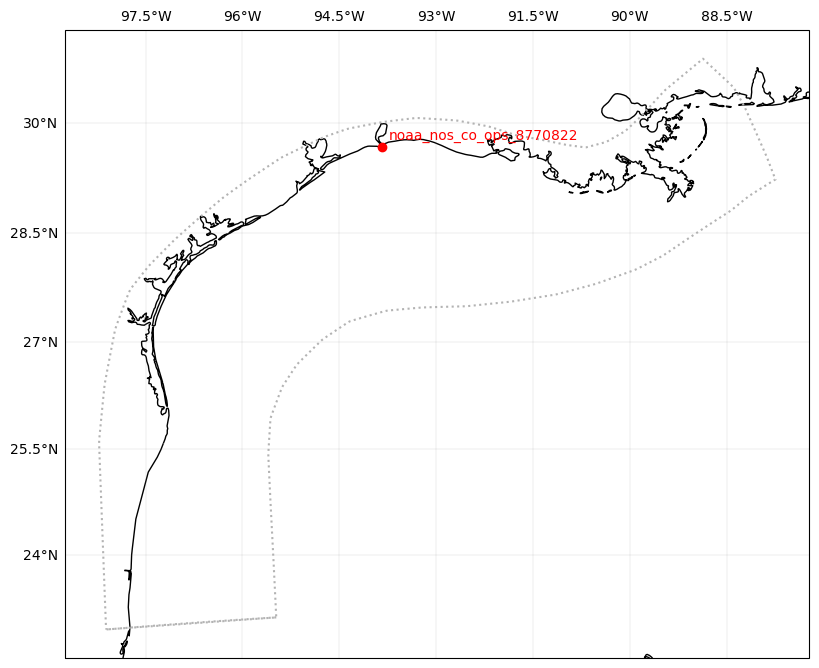

In [16]:
sub = data.meta.loc[[dataset_id],['geospatial_lon_max','geospatial_lat_max']]
lls = sub.values
names = list(sub.index.values)
omsa.map.plot(lls, names, boundary, res='10m')#, extent=[-89,-87,30,31])

In [17]:
obs[dataset_id].cf['ssh']

<xarray.DataArray 'sea_surface_height_above_sea_level_geoid_mllw' (time: 486, timeseries: 1)>
array([[0.679],
       [0.675],
       [0.684],
       [0.684],
       [0.68 ],
       [0.673],
       [0.671],
       [0.663],
       [0.657],
       [0.656],
       [0.652],
       [0.647],
       [0.638],
       [0.635],
       [0.624],
       [0.623],
       [0.628],
       [0.635],
       [0.635],
       [0.632],
...
       [0.54 ],
       [0.551],
       [0.552],
       [0.562],
       [0.559],
       [0.592],
       [0.593],
       [0.602],
       [0.605],
       [0.609],
       [0.612],
       [0.634],
       [0.632],
       [0.65 ],
       [0.643],
       [0.652],
       [0.669],
       [0.666],
       [0.68 ],
       [0.676]])
Coordinates:
  * time       (time) datetime64[ns] 2021-08-09T10:48:00 ... 2021-08-11T10:42:00
    latitude   (timeseries) float64 29.68
    longitude  (timeseries) float64 -93.84
Dimensions without coordinates: timeseries
Attributes:
    actual_range:       [0.019 0.706]
    id:                 546976
    ioos_category:      Other
    long_name:          Water Level
    platform:           station
    standard_name:      sea_surface_height_above_sea_level
    standard_name_url:  http://mmisw.org/ont/cf/parameter/sea_surface_height_...
    vertical_datum:     MLLW
    units:              meter

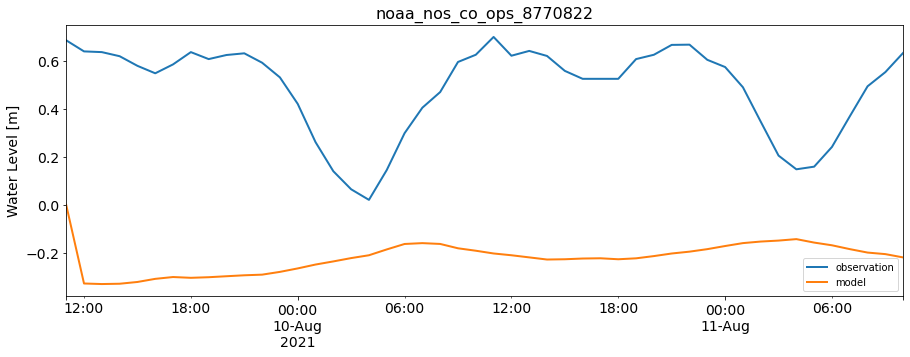

In [18]:
longname = obs[dataset_id].cf['ssh'].attrs['long_name']
units = odg.var_def[key]['units']
ylabel = f'{longname} [{units}]'
df.omsa.plot(title=f'{dataset_id}', ylabel=ylabel)